<a href="https://colab.research.google.com/github/huongnd12/Gradient-Vanishing/blob/main/Gradient_Vanishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

6 methods to avoid Gradient Vanishing: Weight increasing, Better activation, Better Optimizer, Normalize inside network, Skip connection, Train some layers.

# 1.Project Introduction

In this project, Fashion-MNIST dataset is used, including:
- Training set: 60000 samples
- Test set: 10000 samples

Each sample is a grayscale image with the size of 28x28. Image are corresponded to labels from 0 to 9
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

In [ ]:
label_dict = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

I'll use Fashion MNIST dataset and build a MLP model to classify 10 classes on this dataset. However, there are several problems need to be solved when selecting parameters and hyper-parameters.

This project concentrates on solving `Gradient Vanishing` which affects the training performance.

# 2.Problem Introduction

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import matplotlib.pyplot as plt
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
log_dict = {'model_name': [],
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'note': []}

## 2.1. Load data

In [ ]:
# Data preparation
train_dataset = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

batch_size = 512
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 18231836.37it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270851.58it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4984509.80it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20603317.74it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



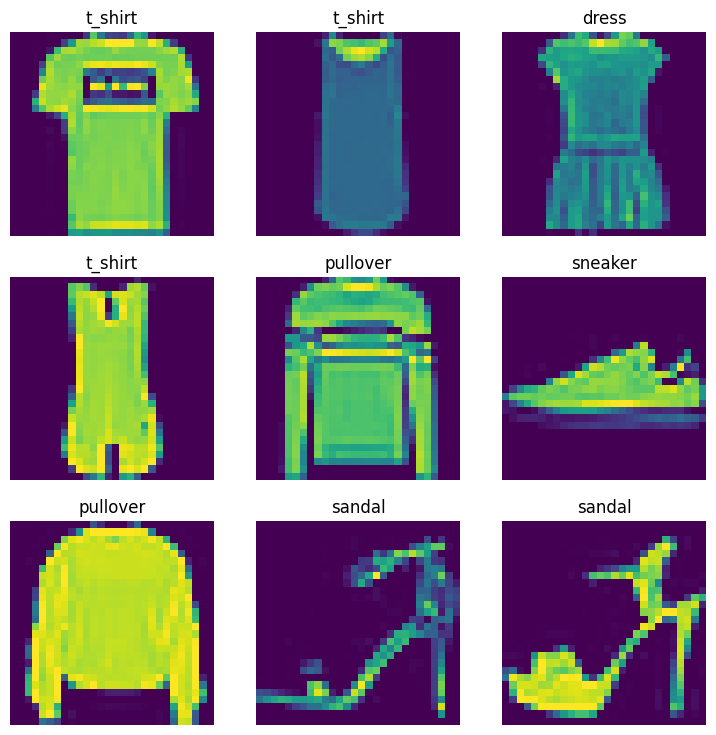

In [ ]:
fig = plt.figure(figsize=(9,9))
for i in range(1, 10, 1):
  data = train_dataset[i]
  img, label = data[0].reshape(28, 28), data[1]
  plt.subplot(3, 3, i)
  plt.imshow(img)
  plt.axis('off')
  plt.title(label_dict[label])

## 2.2. Training and Evaluation

In [ ]:
# One epoch

## Training
def train(model, optimizer, criterion, data_loader, device):
  model.train()
  n_train = len(data_loader.dataset)
  ep_train_loss, ep_train_acc = 0, 0
  for images, labels in data_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    loss = criterion(outputs, labels)
    ep_train_loss += loss.item()
    ep_train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  ep_train_loss /= len(data_loader)
  ep_train_acc /= n_train

  return ep_train_loss, ep_train_acc

## Evaluation
def evaluate(model, criterion, data_loader, device):
  model.eval()
  n_val = len(data_loader.dataset)
  ep_val_loss, ep_val_acc = 0, 0

  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      ep_val_loss += criterion(outputs, labels).item()
      ep_val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
  ep_val_loss /= len(data_loader)
  ep_val_acc /= n_val
  return ep_val_loss, ep_val_acc

## 2.3. Gradient Vanishing

In theory, the deeper we build a model (more hidden layers), the model's ability to learn and represent data will be better than models with fewer layers, but in reality sometimes the result is the opposite. I will train the Fashion MNIST dataset with 3 completely identical models that only differ in the number of hidden layers (the number of layers gradually increases) and observe the results of the models after training evaluated on the test set.

**Model 1:**
- Weight initialization: mean=0, std=0.05
- Hidden layers: `3 layers`
- Activation: Sigmoid
- Nodes: 128
- Loss: CE
- Optimizer: SGD

In [ ]:
class MLP_1(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_1, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, out_dims)
    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = self.linear3(x)
    return x

In [ ]:
model_1 = MLP_1(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_1, train_acc_1 = [], []
val_loss_1, val_acc_1 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_1, optimizer_1, criterion_1, train_loader, device)
  train_loss_1.append(ep_train_loss)
  train_acc_1.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_1, criterion_1, test_loader, device)
  val_loss_1.append(ep_val_loss)
  val_acc_1.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.3054 | Train Accuracy: 0.1009 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 2.3028 | Train Accuracy: 0.0994 | Valid Loss: 2.3025 | Valid Accuracy: 0.0979
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 2.3026 | Train Accuracy: 0.1017 | Valid Loss: 2.3026 | Valid Accuracy: 0.0999
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 2.3026 | Train Accuracy: 0.1021 | Valid Loss: 2.3024 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 2.3025 | Train Accuracy: 0.1037 | Valid Loss: 2.3024 | Valid Accuracy: 0.1000
----------------

In [ ]:
# Save log
log_dict['model_name'].append('model_1')
log_dict['train_loss'].append(train_loss_1)
log_dict['train_accuracy'].append(train_acc_1)
log_dict['val_loss'].append(val_loss_1)
log_dict['val_accuracy'].append(val_acc_1)

**Model 2:**
- Weight initialization: mean=0, std=0.05
- Hidden layers: `5 layers`
- Activation: Sigmoid
- Nodes: 128
- Loss: CE
- Optimizer: SGD

In [ ]:
class MLP_2(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_2, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    x = self.sigmoid(self.linear4(x))
    x = self.linear5(x)
    return x

In [ ]:
model_2 = MLP_2(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(model_2.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_2, train_acc_2 = [], []
val_loss_2, val_acc_2 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_2, optimizer_2, criterion_2, train_loader, device)
  train_loss_2.append(ep_train_loss)
  train_acc_2.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_2, criterion_2, test_loader, device)
  val_loss_2.append(ep_val_loss)
  val_acc_2.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.3072 | Train Accuracy: 0.0988 | Valid Loss: 2.3026 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 2.3028 | Train Accuracy: 0.1009 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 2.3028 | Train Accuracy: 0.0972 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 2.3028 | Train Accuracy: 0.0987 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 2.3028 | Train Accuracy: 0.0995 | Valid Loss: 2.3028 | Valid Accuracy: 0.1000
----------------

In [ ]:
# Save log
log_dict['model_name'].append('model_2')
log_dict['train_loss'].append(train_loss_2)
log_dict['train_accuracy'].append(train_acc_2)
log_dict['val_loss'].append(val_loss_2)
log_dict['val_accuracy'].append(val_acc_2)

**Model 3:**
- Weight initialization: mean=0, std=0.05
- Hidden layers: `7 layers`
- Activation: Sigmoid
- Nodes: 128
- Loss: CE
- Optimizer: SGD

In [ ]:
class MLP_3(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_3, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    x = self.sigmoid(self.linear4(x))
    x = self.sigmoid(self.linear5(x))
    x = self.sigmoid(self.linear6(x))
    x = self.linear7(x)
    return x

In [ ]:
model_3 = MLP_3(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.SGD(model_3.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_3, train_acc_3 = [], []
val_loss_3, val_acc_3 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_3, optimizer_3, criterion_3, train_loader, device)
  train_loss_3.append(ep_train_loss)
  train_acc_3.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_3, criterion_3, test_loader, device)
  val_loss_3.append(ep_val_loss)
  val_acc_3.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.3076 | Train Accuracy: 0.1001 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 2.3028 | Train Accuracy: 0.0993 | Valid Loss: 2.3028 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 2.3028 | Train Accuracy: 0.0999 | Valid Loss: 2.3028 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 2.3028 | Train Accuracy: 0.0969 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 2.3028 | Train Accuracy: 0.0982 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
----------------

In [ ]:
# Save log
log_dict['model_name'].append('model_3')
log_dict['train_loss'].append(train_loss_3)
log_dict['train_accuracy'].append(train_acc_3)
log_dict['val_loss'].append(val_loss_3)
log_dict['val_accuracy'].append(val_acc_3)

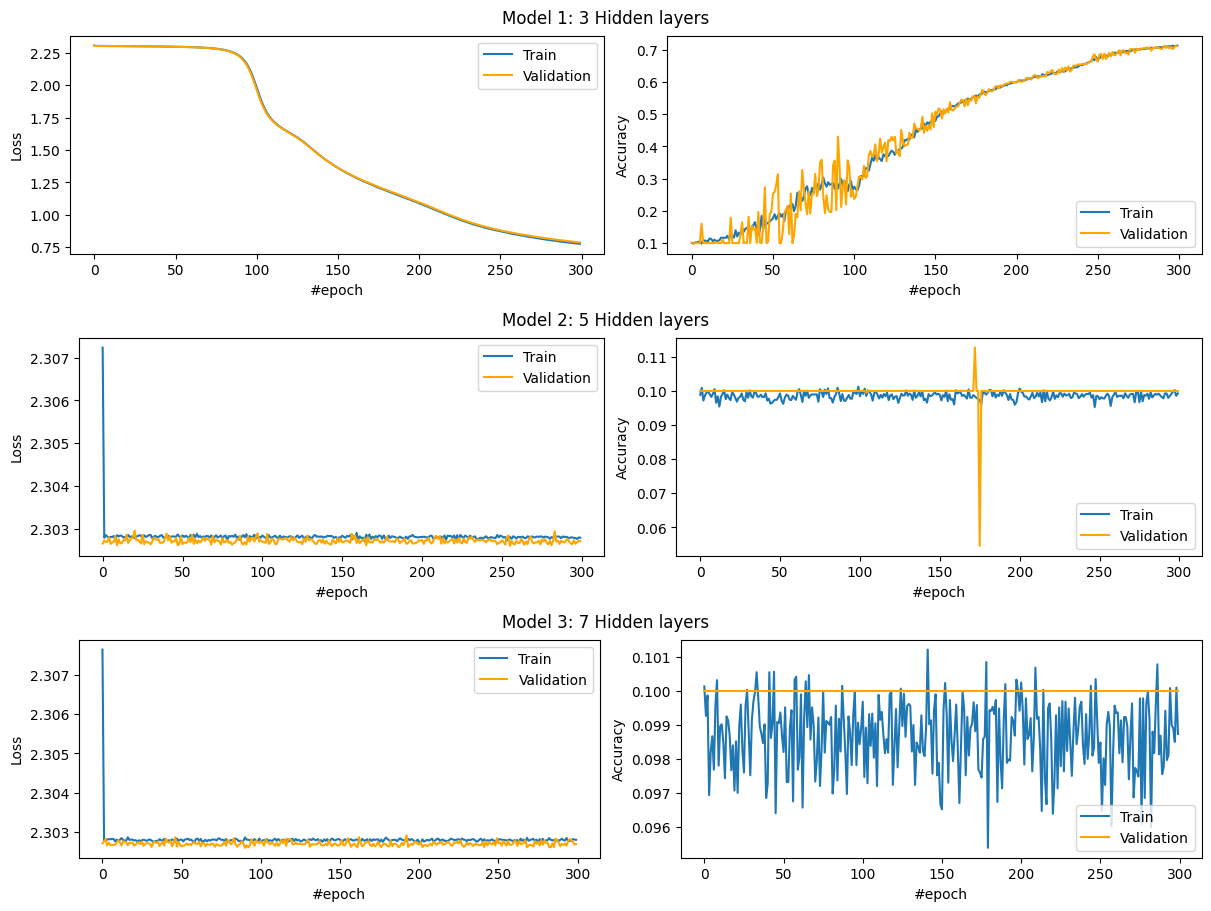

In [ ]:
train_loss_des = log_dict['train_loss'][:3]
val_loss_des = log_dict['val_loss'][:3]
train_acc_des = log_dict['train_accuracy'][:3]
val_acc_des = log_dict['val_accuracy'][:3]

fig = plt.figure(constrained_layout=True, figsize=(12,9))
subfigs = fig.subfigures(3, 1)
for i, subfig in enumerate(subfigs):
  axes = subfig.subplots(1, 2)

  axes[0].plot(train_loss_des[i], label='Train')
  axes[0].plot(val_loss_des[i], color='orange', label='Validation')
  axes[0].legend(loc=1)
  axes[0].set_xlabel('#epoch')
  axes[0].set_ylabel('Loss')

  axes[1].plot(train_acc_des[i], label='Train')
  axes[1].plot(val_acc_des[i], color='orange', label='Validation')
  axes[1].legend(loc=4)
  axes[1].set_xlabel('#epoch')
  axes[1].set_ylabel('Accuracy')

  subfig.suptitle(f'Model {i+1}: {3 + i*2} Hidden layers')

plt.show()



- 3 hidden layers: training process converges after 300 epochs. The loss reduces from 2.3 to 0.8, reaching accuracy score at about 70%.
- 5 and 7 hidden layers: the loss is almost not reduced. The accuracy stays around 10%.

To summary, with same parameters, the deeper the model, the worse performance. In the model 2 and 3, the loss does nearly not decrease. This is a sign of the Gradient Vanishing.

# 3.Solution

## 3.1. Weight increasing

The initial weights were created at the mean of 0 and standard deviation of 0.05. This made initial weights too small, resulting in Gradient Vanishing.

I'll try to increase variance to 1 and 10 to compare results as below.

### 3.1.1. Standard Deviation = 1.0

In [ ]:
class MLP_4(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_4, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=1.0)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    x = self.sigmoid(self.linear4(x))
    x = self.sigmoid(self.linear5(x))
    x = self.sigmoid(self.linear6(x))
    x = self.linear7(x)
    return x

In [ ]:
model_4 = MLP_4(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = torch.optim.SGD(model_4.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_4, train_acc_4 = [], []
val_loss_4, val_acc_4 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_4, optimizer_4, criterion_4, train_loader, device)
  train_loss_4.append(ep_train_loss)
  train_acc_4.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_4, criterion_4, test_loader, device)
  val_loss_4.append(ep_val_loss)
  val_acc_4.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 3.0606 | Train Accuracy: 0.1694 | Valid Loss: 2.0804 | Valid Accuracy: 0.2553
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 1.9357 | Train Accuracy: 0.3165 | Valid Loss: 1.8045 | Valid Accuracy: 0.3681
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 1.7080 | Train Accuracy: 0.4067 | Valid Loss: 1.6253 | Valid Accuracy: 0.4284
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 1.5557 | Train Accuracy: 0.4582 | Valid Loss: 1.5005 | Valid Accuracy: 0.4694
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 1.4485 | Train Accuracy: 0.4910 | Valid Loss: 1.4103 | Valid Accuracy: 0.4990
----------------

In [ ]:
# Save log
log_dict['model_name'].append('model_4')
log_dict['train_loss'].append(train_loss_4)
log_dict['train_accuracy'].append(train_acc_4)
log_dict['val_loss'].append(val_loss_4)
log_dict['val_accuracy'].append(val_acc_4)

### 3.1.2. Standard Deviation = 10.0

In [ ]:
class MLP_5(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_5, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=10.0)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    x = self.sigmoid(self.linear4(x))
    x = self.sigmoid(self.linear5(x))
    x = self.sigmoid(self.linear6(x))
    x = self.linear7(x)
    return x

In [ ]:
model_5 = MLP_5(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = torch.optim.SGD(model_5.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_5, train_acc_5 = [], []
val_loss_5, val_acc_5 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_5, optimizer_5, criterion_5, train_loader, device)
  train_loss_5.append(ep_train_loss)
  train_acc_5.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_5, criterion_5, test_loader, device)
  val_loss_5.append(ep_val_loss)
  val_acc_5.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 111.0014 | Train Accuracy: 0.1021 | Valid Loss: 93.5130 | Valid Accuracy: 0.0987
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 80.2115 | Train Accuracy: 0.0997 | Valid Loss: 70.2124 | Valid Accuracy: 0.0994
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 64.7981 | Train Accuracy: 0.1045 | Valid Loss: 57.9463 | Valid Accuracy: 0.0999
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 52.5105 | Train Accuracy: 0.1077 | Valid Loss: 46.0098 | Valid Accuracy: 0.1370
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 41.8865 | Train Accuracy: 0.1188 | Valid Loss: 39.2381 | Valid Accuracy: 0.1261
-----

In [ ]:
# Save log
log_dict['model_name'].append('model_5')
log_dict['train_loss'].append(train_loss_5)
log_dict['train_accuracy'].append(train_acc_5)
log_dict['val_loss'].append(val_loss_5)
log_dict['val_accuracy'].append(val_acc_5)

### 3.1.3. Summary

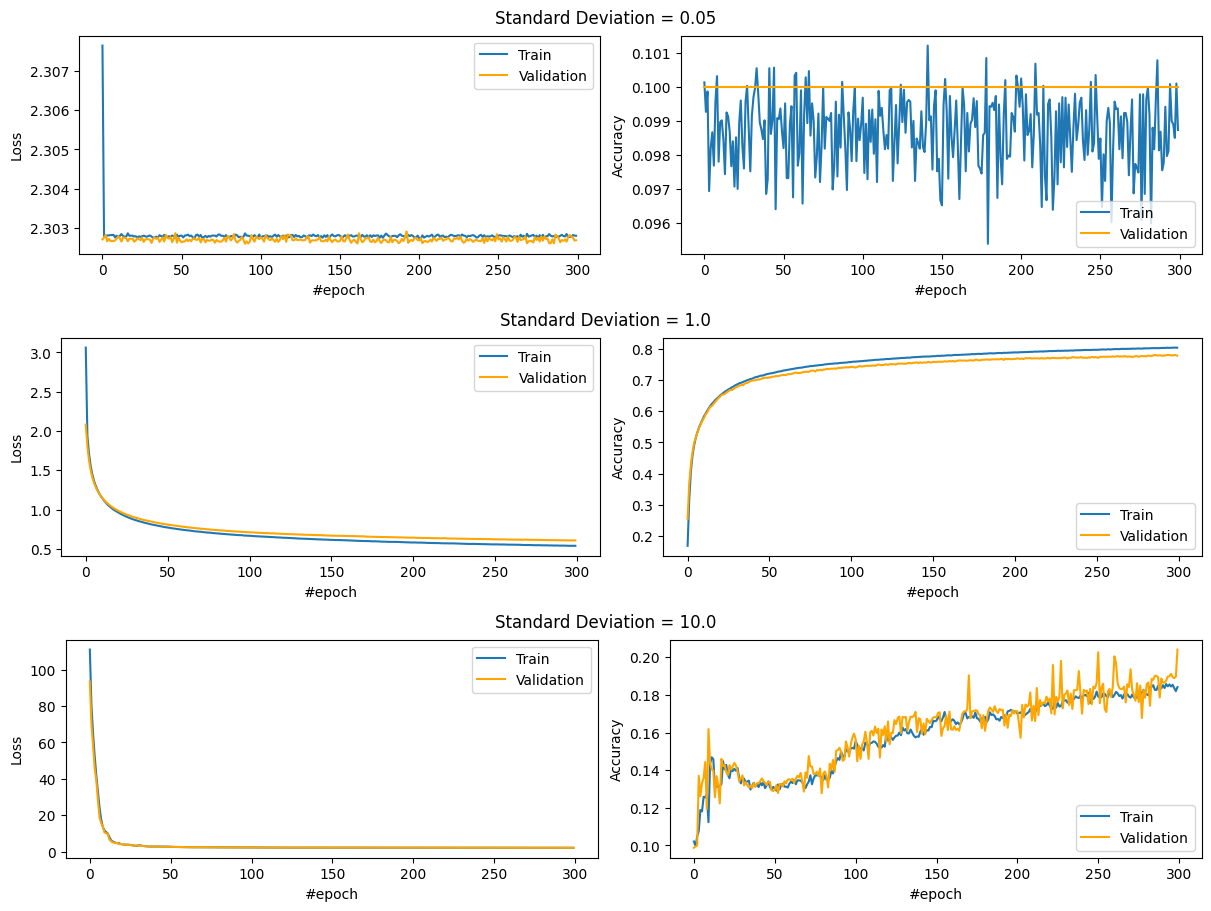

In [ ]:
train_loss_w = log_dict['train_loss'][2:5]
val_loss_w = log_dict['val_loss'][2:5]
train_acc_w = log_dict['train_accuracy'][2:5]
val_acc_w = log_dict['val_accuracy'][2:5]
std = [0.05, 1.0, 10.0]

fig = plt.figure(constrained_layout=True, figsize=(12,9))
subfigs = fig.subfigures(3, 1)
for i, subfig in enumerate(subfigs):
  axes = subfig.subplots(1, 2)

  axes[0].plot(train_loss_w[i], label='Train')
  axes[0].plot(val_loss_w[i], color='orange', label='Validation')
  axes[0].legend(loc=1)
  axes[0].set_xlabel('#epoch')
  axes[0].set_ylabel('Loss')

  axes[1].plot(train_acc_w[i], label='Train')
  axes[1].plot(val_acc_w[i], color='orange', label='Validation')
  axes[1].legend(loc=4)
  axes[1].set_xlabel('#epoch')
  axes[1].set_ylabel('Accuracy')

  subfig.suptitle(f'Standard Deviation = {std[i]}')

plt.show()

- Standard deviation = 1.0: The distribution at wider variance helps initial weight not too small. Thus, the model avoids Gradient Vanishing and reaches accuracy score at nearly 80% after 300 epochs.
- Standard deviation = 10.0: Despite of wider variance, this variance is too large, resulting in big initial weights. Since Sigmoid is used as activation function, the gradient steps toward 0 when the value of variables become bigger and bigger. Thus, this initial weight distribution makes the model meet Gradient Vanishing.

In conclusion, the initial weights of model should has a reasonable variance to overcome the Gradient Vanishing.

## 3.2. Better activation

With Sigmoid activation function, the gradient will be vanished when the variable value becomes larger. ReLU activation function will help model overcome this problem.

In [ ]:
class MLP_6(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_6, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.relu = nn.ReLU()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.linear_in(x))
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.relu(self.linear3(x))
    x = self.relu(self.linear4(x))
    x = self.relu(self.linear5(x))
    x = self.relu(self.linear6(x))
    x = self.linear7(x)
    return x

In [ ]:
model_6 = MLP_6(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_6 = nn.CrossEntropyLoss()
optimizer_6 = torch.optim.SGD(model_6.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_6, train_acc_6 = [], []
val_loss_6, val_acc_6 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_6, optimizer_6, criterion_6, train_loader, device)
  train_loss_6.append(ep_train_loss)
  train_acc_6.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_6, criterion_6, test_loader, device)
  val_loss_6.append(ep_val_loss)
  val_acc_6.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.3025 | Train Accuracy: 0.1455 | Valid Loss: 2.3023 | Valid Accuracy: 0.1753
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 2.3022 | Train Accuracy: 0.1901 | Valid Loss: 2.3021 | Valid Accuracy: 0.1034
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 2.3021 | Train Accuracy: 0.1343 | Valid Loss: 2.3020 | Valid Accuracy: 0.1223
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 2.3019 | Train Accuracy: 0.1856 | Valid Loss: 2.3018 | Valid Accuracy: 0.1085
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 2.3017 | Train Accuracy: 0.1050 | Valid Loss: 2.3016 | Valid Accuracy: 0.1882
----------------

In [ ]:
# Save log
log_dict['model_name'].append('model_6')
log_dict['train_loss'].append(train_loss_6)
log_dict['train_accuracy'].append(train_acc_6)
log_dict['val_loss'].append(val_loss_6)
log_dict['val_accuracy'].append(val_acc_6)

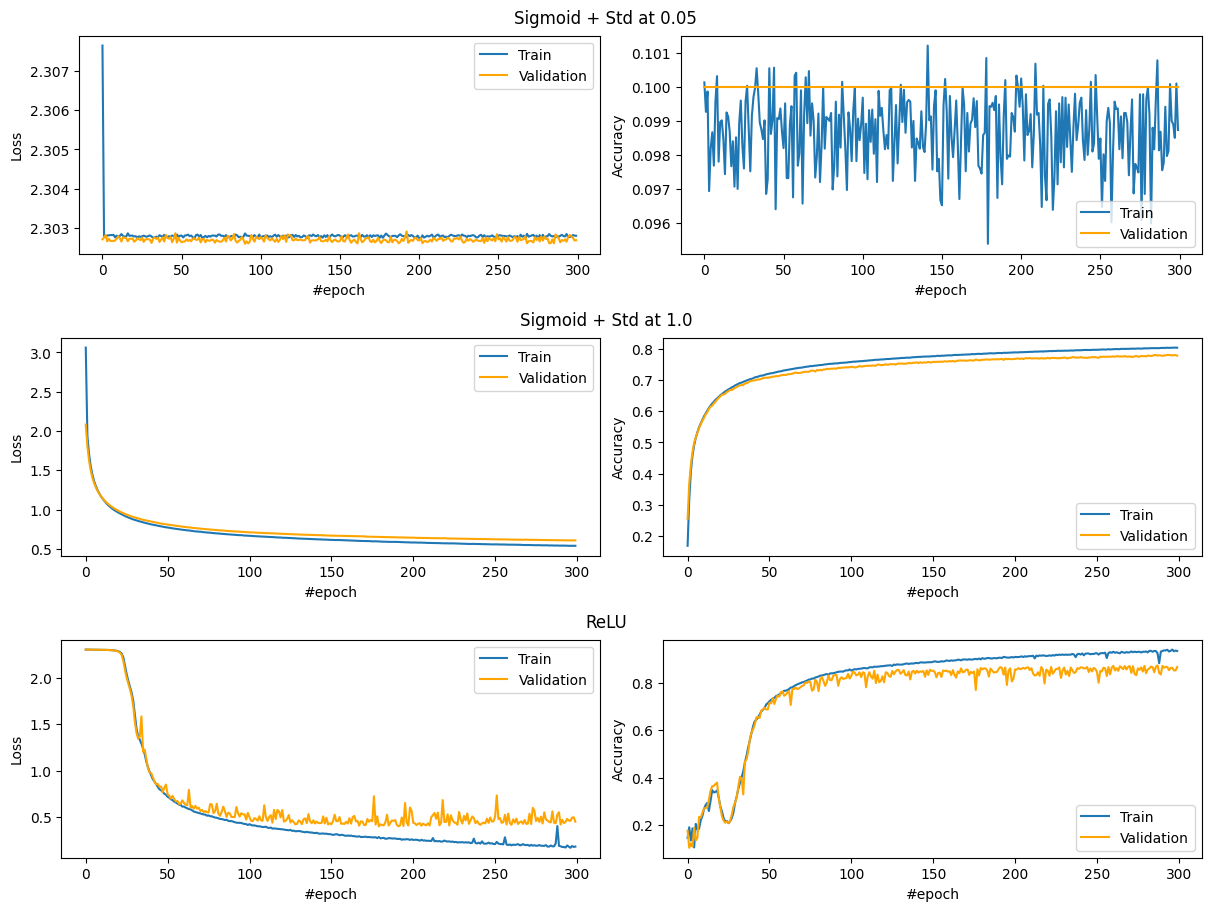

In [ ]:
idx_act = [2, 3, 5]
train_loss_act = [log_dict['train_loss'][i] for i in idx_act]
val_loss_act = [log_dict['val_loss'][i] for i in idx_act]
train_acc_act = [log_dict['train_accuracy'][i] for i in idx_act]
val_acc_act = [log_dict['val_accuracy'][i] for i in idx_act]
activations = ['Sigmoid + Std at 0.05', 'Sigmoid + Std at 1.0', 'ReLU']

fig = plt.figure(constrained_layout=True, figsize=(12,9))
subfigs = fig.subfigures(3, 1)
for i, subfig in enumerate(subfigs):
  axes = subfig.subplots(1, 2)

  axes[0].plot(train_loss_act[i], label='Train')
  axes[0].plot(val_loss_act[i], color='orange', label='Validation')
  axes[0].legend(loc=1)
  axes[0].set_xlabel('#epoch')
  axes[0].set_ylabel('Loss')

  axes[1].plot(train_acc_act[i], label='Train')
  axes[1].plot(val_acc_act[i], color='orange', label='Validation')
  axes[1].legend(loc=4)
  axes[1].set_xlabel('#epoch')
  axes[1].set_ylabel('Accuracy')

  subfig.suptitle(f'{activations[i]}')

plt.show()

Despite small initial weights, the ReLU function which has derivation of 1 at any variable value larger than 0 helps the model overcome the Gradient Vanishing. Although the speed in increasing accuracy is slower than when using Sigmoid with standard deviation of initial weights at 1.0, after 300 epochs, the training set using ReLU reaches higher score at around 93%. In addition, the adventage of ReLU over Sigmoid is ReLU's highest derivative is 1 while Sigmoid's highest derivative is just around 0.25.

## 3.3. Better optimizer

Above models are trained under Stochastic Gradient Descent with fixed learning rate. In this section, learning rate is a parameter which will be updated based on the magnitude of gradient and the histotical value. Meanwhile, the direction and value of historical gradient will affect the current gradient. This is `Adam Optimizer` which will help the model avoid the gradient vanishing and overcome local minimum.



In [ ]:
class MLP_7(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_7, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    x = self.sigmoid(self.linear4(x))
    x = self.sigmoid(self.linear5(x))
    x = self.sigmoid(self.linear6(x))
    x = self.linear7(x)
    return x

In [ ]:
model_7 = MLP_7(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_7 = nn.CrossEntropyLoss()

# Learning rate of 0.001
optimizer_7 = torch.optim.Adam(model_7.parameters(),
                               lr=0.001)

In [ ]:
num_epochs = 300
train_loss_7, train_acc_7 = [], []
val_loss_7, val_acc_7 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_7, optimizer_7, criterion_7, train_loader, device)
  train_loss_7.append(ep_train_loss)
  train_acc_7.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_7, criterion_7, test_loader, device)
  val_loss_7.append(ep_val_loss)
  val_acc_7.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.1724 | Train Accuracy: 0.1378 | Valid Loss: 1.7097 | Valid Accuracy: 0.1998
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 1.6926 | Train Accuracy: 0.1989 | Valid Loss: 1.6884 | Valid Accuracy: 0.1996
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 1.6829 | Train Accuracy: 0.2002 | Valid Loss: 1.6855 | Valid Accuracy: 0.2016
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 1.6692 | Train Accuracy: 0.2105 | Valid Loss: 1.6155 | Valid Accuracy: 0.2883
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 1.4480 | Train Accuracy: 0.3439 | Valid Loss: 1.3373 | Valid Accuracy: 0.4550
----------------

In [ ]:
# Save log
log_dict['model_name'].append('model_7')
log_dict['train_loss'].append(train_loss_7)
log_dict['train_accuracy'].append(train_acc_7)
log_dict['val_loss'].append(val_loss_7)
log_dict['val_accuracy'].append(val_acc_7)

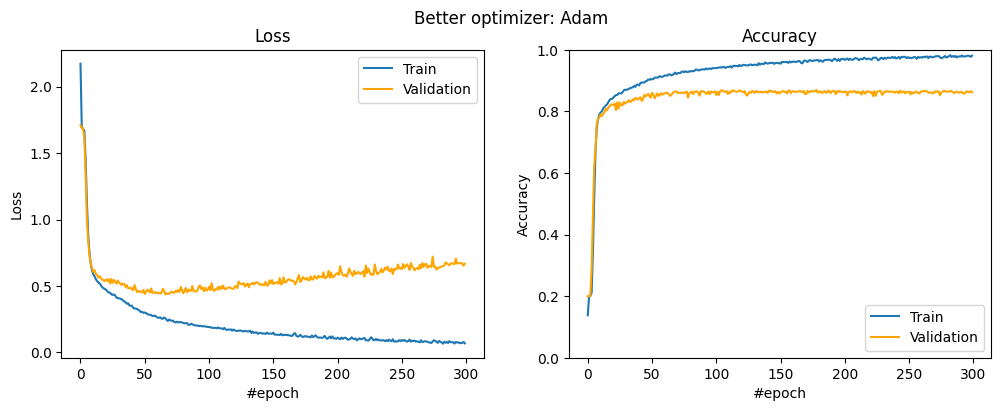

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_7, label='Train')
plt.plot(val_loss_7, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_7, label='Train')
plt.plot(val_acc_7, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracy')

plt.suptitle('Better optimizer: Adam')
plt.show()

The accuracy increasing speed when using Adam is quickest in compared to above methods. The score of training set nearly achives 100% after 300 epochs.

## 3.4. Normalize inside network

### 3.4.1. Batch Normalization

The change in the distributions of layers' inputs presents a problem because the layers need to continuously adapt to the new distribution.

In this section, I'll introduce a technique called `Batch Normalization` as a solution for Gradient Vanishing.

Batch Normalization, that takes a step towards reducing internal covariate shift, and in doing so dramatically accelerates the training of deep neural nets. It accomplishes this via a normalization step that fixes the means and variances of layer inputs. Batch Normalization
also has a beneficial effect on the gradient flow through the network, by reducing the dependence of gradients on the scale of the parameters or of their initial values. This allows us to use much higher learning rates without the risk of divergence.

In [ ]:
class MLP_8(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_8, self).__init__()
    self.hidden_dims = hidden_dims
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear_in(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    x = self.linear1(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    x = self.linear2(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    x = self.linear3(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    x = self.linear4(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    x = self.linear5(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    x = self.linear6(x)
    x = nn.BatchNorm1d(num_features=self.hidden_dims, device=device)(x)
    x = self.sigmoid(x)
    out = self.linear7(x)
    return out

In [ ]:
model_8 = MLP_8(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_8 = nn.CrossEntropyLoss()
optimizer_8 = torch.optim.SGD(model_8.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_8, train_acc_8 = [], []
val_loss_8, val_acc_8 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_8, optimizer_8, criterion_8, train_loader, device)
  train_loss_8.append(ep_train_loss)
  train_acc_8.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_8, criterion_8, test_loader, device)
  val_loss_8.append(ep_val_loss)
  val_acc_8.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 1.9000 | Train Accuracy: 0.5648 | Valid Loss: 1.6384 | Valid Accuracy: 0.6892
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 1.4851 | Train Accuracy: 0.7218 | Valid Loss: 1.3591 | Valid Accuracy: 0.7382
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 1.2591 | Train Accuracy: 0.7536 | Valid Loss: 1.1771 | Valid Accuracy: 0.7561
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 1.1019 | Train Accuracy: 0.7716 | Valid Loss: 1.0458 | Valid Accuracy: 0.7709
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 0.9861 | Train Accuracy: 0.7842 | Valid Loss: 0.9471 | Valid Accuracy: 0.7808
----------------

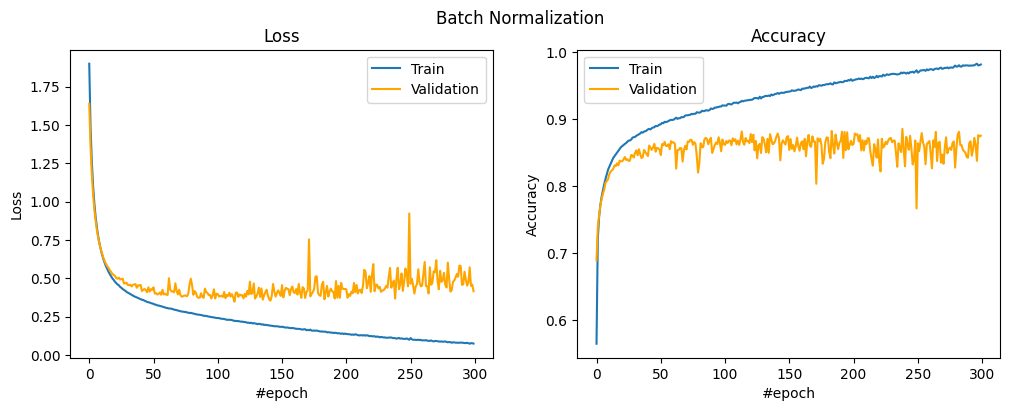

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_8, label='Train')
plt.plot(val_loss_8, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_8, label='Train')
plt.plot(val_acc_8, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.suptitle('Batch Normalization')
plt.show()

Batch Normalization gives better performance with accuracy scores of around 98% and 85% in the training set and validation set respectively.

In [ ]:
# Save log
log_dict['model_name'].append('model_8')
log_dict['train_loss'].append(train_loss_8)
log_dict['train_accuracy'].append(train_acc_8)
log_dict['val_loss'].append(val_loss_8)
log_dict['val_accuracy'].append(val_acc_8)

### 3.4.2. Custom Normalization

In [ ]:
class MyNorm(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    mean = torch.mean(x)
    std = torch.std(x)
    return (x - mean)/(std + 10**-6)


In [ ]:
class MLP_9(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_9, self).__init__()
    self.hidden_dims = hidden_dims
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear_in(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    x = self.linear1(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    x = self.linear2(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    x = self.linear3(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    x = self.linear4(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    x = self.linear5(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    x = self.linear6(x)
    x = MyNorm()(x)
    x = self.sigmoid(x)
    out = self.linear7(x)
    return out

In [ ]:
model_9 = MLP_9(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_9 = nn.CrossEntropyLoss()
optimizer_9 = torch.optim.SGD(model_9.parameters(),
                              lr=0.01)

In [ ]:
num_epochs = 300
train_loss_9, train_acc_9 = [], []
val_loss_9, val_acc_9 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_9, optimizer_9, criterion_9, train_loader, device)
  train_loss_9.append(ep_train_loss)
  train_acc_9.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_9, criterion_9, test_loader, device)
  val_loss_9.append(ep_val_loss)
  val_acc_9.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.3123 | Train Accuracy: 0.0990 | Valid Loss: 2.3026 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 2.3028 | Train Accuracy: 0.0990 | Valid Loss: 2.3028 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 2.3028 | Train Accuracy: 0.0997 | Valid Loss: 2.3027 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 2.3028 | Train Accuracy: 0.0988 | Valid Loss: 2.3028 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 2.3028 | Train Accuracy: 0.0989 | Valid Loss: 2.3026 | Valid Accuracy: 0.1000
----------------

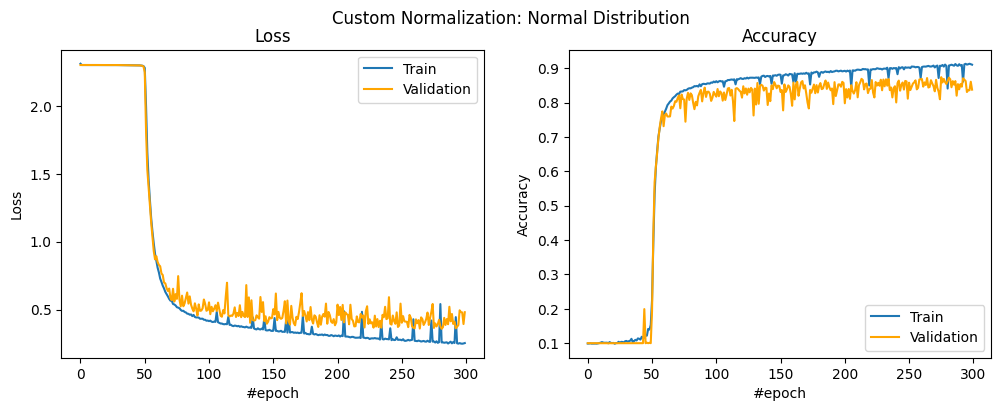

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_9, label='Train')
plt.plot(val_loss_9, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_9, label='Train')
plt.plot(val_acc_9, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.suptitle('Custom Normalization: Normal Distribution')
plt.show()

With the custom normalization for inputs of each layer, the performance of model also looks good.

In [ ]:
# Save log
log_dict['model_name'].append('model_9')
log_dict['train_loss'].append(train_loss_9)
log_dict['train_accuracy'].append(train_acc_9)
log_dict['val_loss'].append(val_loss_9)
log_dict['val_accuracy'].append(val_acc_9)

## 3.5. Skip Connection

I would like to mention about Residual Connection technique in this section. Residual connection provides another path for data to reach latter parts of the neural network by skipping some layers. I'll build a network architecture as below.

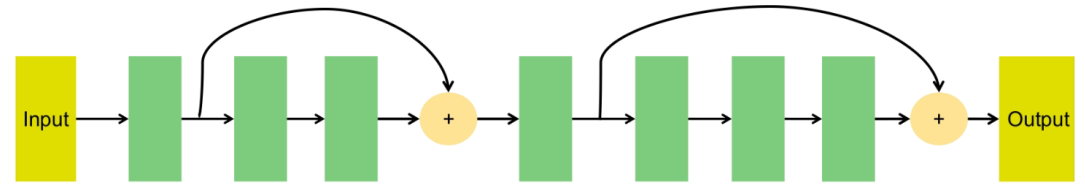

In [ ]:
class MLP_10(nn.Module):
  def __init__(self, in_dims, hidden_dims, out_dims):
    super(MLP_10, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_in = nn.Linear(in_dims, hidden_dims)
    self.linear1 = nn.Linear(hidden_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.linear3 = nn.Linear(hidden_dims, hidden_dims)
    self.linear4 = nn.Linear(hidden_dims, hidden_dims)
    self.linear5 = nn.Linear(hidden_dims, hidden_dims)
    self.linear6 = nn.Linear(hidden_dims, hidden_dims)
    self.linear7 = nn.Linear(hidden_dims, out_dims)

    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = self.flatten(x)
    x = self.sigmoid(self.linear_in(x))
    skip = x
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    x = skip + x
    x = self.sigmoid(self.linear3(x))
    skip = x
    x = self.sigmoid(self.linear4(x))
    x = self.sigmoid(self.linear5(x))
    x = self.sigmoid(self.linear6(x))
    x = skip + x
    x = self.linear7(x)
    return x

In [ ]:
model_10 = MLP_10(in_dims=28*28, hidden_dims=128, out_dims=10).to(device)
criterion_10 = nn.CrossEntropyLoss()
optimizer_10 = torch.optim.SGD(model_10.parameters(),
                               lr=0.01)

In [ ]:
num_epochs = 300
train_loss_10, train_acc_10 = [], []
val_loss_10, val_acc_10 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model_10, optimizer_10, criterion_10, train_loader, device)
  train_loss_10.append(ep_train_loss)
  train_acc_10.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model_10, criterion_10, test_loader, device)
  val_loss_10.append(ep_val_loss)
  val_acc_10.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/300:
Train Loss: 2.3072 | Train Accuracy: 0.0886 | Valid Loss: 2.3031 | Valid Accuracy: 0.1071
--------------------------------------------------
--------------------------------------------------
Epoch   2/300:
Train Loss: 2.3018 | Train Accuracy: 0.1111 | Valid Loss: 2.3021 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   3/300:
Train Loss: 2.2992 | Train Accuracy: 0.1159 | Valid Loss: 2.2979 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   4/300:
Train Loss: 2.2962 | Train Accuracy: 0.1300 | Valid Loss: 2.2953 | Valid Accuracy: 0.1084
--------------------------------------------------
--------------------------------------------------
Epoch   5/300:
Train Loss: 2.2936 | Train Accuracy: 0.1545 | Valid Loss: 2.2922 | Valid Accuracy: 0.1468
----------------

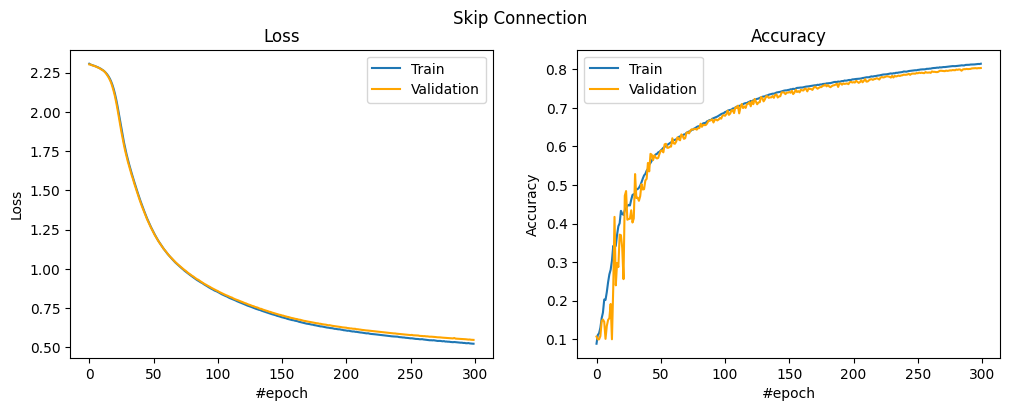

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_10, label='Train')
plt.plot(val_loss_10, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_10, label='Train')
plt.plot(val_acc_10, color='orange', label='Validation')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.suptitle('Skip Connection')
plt.show()

In [ ]:
# Save log
log_dict['model_name'].append('model_10')
log_dict['train_loss'].append(train_loss_10)
log_dict['train_accuracy'].append(train_acc_10)
log_dict['val_loss'].append(val_loss_10)
log_dict['val_accuracy'].append(val_acc_10)

## 3.6. Train some layers

The section will use the strategy of dividing the current model into 4 sub models and performing training 7 times with each time piling the sub models on top of each other and alternately freezing and unzfreezing weights of these sub models.

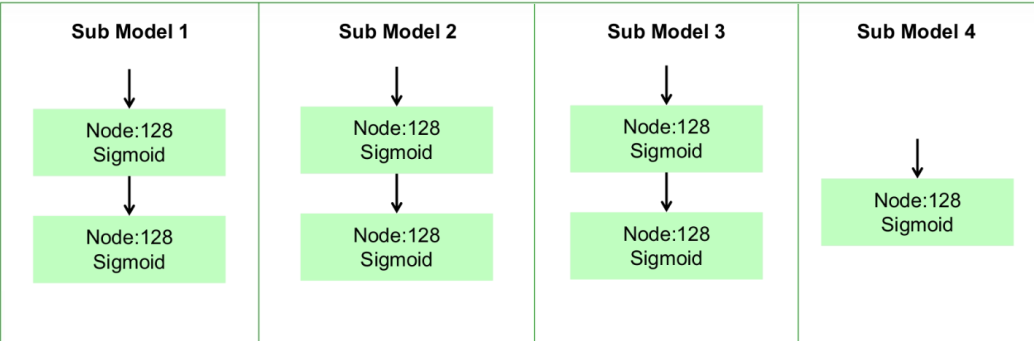

In [ ]:
# Create 2-layers MLP sub-model class
class SubMLP_2layers(nn.Module):
  def __init__(self, in_dims, hidden_dims):
    super(SubMLP_2layers, self).__init__()
    self.linear1 = nn.Linear(in_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.sigmoid(self.linear1(x))
    x = self.sigmoid(self.linear2(x))
    return x

# Create 1-layer MLP sub-model class
class SubMLP_1layer(nn.Module):
  def __init__(self, in_dims, hidden_dims):
    super(SubMLP_1layer, self).__init__()
    self.linear = nn.Linear(in_dims, hidden_dims)
    self.sigmoid = nn.Sigmoid()

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.05)
        nn.init.constant_(m.bias, 0.0)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.sigmoid(self.linear(x))
    return x

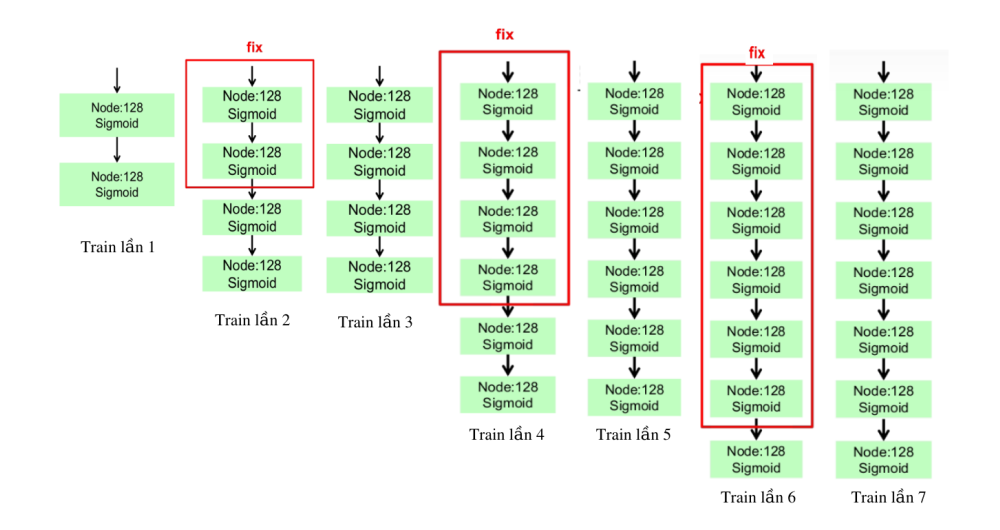

In [ ]:
sub_1 = SubMLP_2layers(in_dims=28*28, hidden_dims=128)
sub_2 = SubMLP_2layers(in_dims=128, hidden_dims=128)
sub_3 = SubMLP_2layers(in_dims=128, hidden_dims=128)
sub_4 = SubMLP_1layer(in_dims=128, hidden_dims=128)

### 3.6.1. Train 1

In [ ]:
# Train 1 (Train sub-model 1) with 100 epochs
model = nn.Sequential(
    sub_1,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_1, train_acc_6_1 = [], []
val_loss_6_1, val_acc_6_1 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_1.append(ep_train_loss)
  train_acc_6_1.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_1.append(ep_val_loss)
  val_acc_6_1.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.3022 | Train Accuracy: 0.1454 | Valid Loss: 2.2960 | Valid Accuracy: 0.1692
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 2.2944 | Train Accuracy: 0.1849 | Valid Loss: 2.2925 | Valid Accuracy: 0.1988
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 2.2909 | Train Accuracy: 0.2187 | Valid Loss: 2.2889 | Valid Accuracy: 0.2219
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 2.2871 | Train Accuracy: 0.2487 | Valid Loss: 2.2850 | Valid Accuracy: 0.3271
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 2.2830 | Train Accuracy: 0.3197 | Valid Loss: 2.2806 | Valid Accuracy: 0.2862
----------------

### 3.6.2. Train 2

In [ ]:
# Train 2
## Combine sub-model 1 and sub-model 2
## Fix weights of sub-model 1 from Train 1
for param in sub_1.parameters():
  param.requires_grad = False

model = nn.Sequential(
    sub_1,
    sub_2,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_2, train_acc_6_2 = [], []
val_loss_6_2, val_acc_6_2 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_2.append(ep_train_loss)
  train_acc_6_2.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_2.append(ep_val_loss)
  val_acc_6_2.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.3067 | Train Accuracy: 0.1056 | Valid Loss: 2.3012 | Valid Accuracy: 0.1667
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 2.3010 | Train Accuracy: 0.1172 | Valid Loss: 2.3006 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 2.3004 | Train Accuracy: 0.1394 | Valid Loss: 2.2999 | Valid Accuracy: 0.1512
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 2.2998 | Train Accuracy: 0.1461 | Valid Loss: 2.2993 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 2.2990 | Train Accuracy: 0.1418 | Valid Loss: 2.2986 | Valid Accuracy: 0.2553
----------------

### 3.6.3. Train 3

In [ ]:
# Train 3
## Combine sub-model 1 and sub-model 2

for param in sub_1.parameters():
  param.requires_grad = True

model = nn.Sequential(
    sub_1,
    sub_2,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_3, train_acc_6_3 = [], []
val_loss_6_3, val_acc_6_3 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_3.append(ep_train_loss)
  train_acc_6_3.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_3.append(ep_val_loss)
  val_acc_6_3.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.0947 | Train Accuracy: 0.3137 | Valid Loss: 1.9280 | Valid Accuracy: 0.4186
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 1.8181 | Train Accuracy: 0.4889 | Valid Loss: 1.7254 | Valid Accuracy: 0.5162
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 1.6553 | Train Accuracy: 0.5296 | Valid Loss: 1.5960 | Valid Accuracy: 0.5259
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 1.5458 | Train Accuracy: 0.5366 | Valid Loss: 1.5040 | Valid Accuracy: 0.5424
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 1.4658 | Train Accuracy: 0.5444 | Valid Loss: 1.4348 | Valid Accuracy: 0.5591
----------------

### 3.6.4. Train 4

In [ ]:
# Train 4
## Combine sub-model 1, sub-model 2 and sub-model 3
## Fix weights of sub-models 1 and 2 from Train 3

for param in sub_1.parameters():
  param.requires_grad = False

for param in sub_2.parameters():
  param.requires_grad = False

model = nn.Sequential(
    sub_1,
    sub_2,
    sub_3,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_4, train_acc_6_4 = [], []
val_loss_6_4, val_acc_6_4 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_4.append(ep_train_loss)
  train_acc_6_4.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_4.append(ep_val_loss)
  val_acc_6_4.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.3041 | Train Accuracy: 0.0984 | Valid Loss: 2.3019 | Valid Accuracy: 0.0005
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 2.3015 | Train Accuracy: 0.1041 | Valid Loss: 2.3010 | Valid Accuracy: 0.1178
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 2.3006 | Train Accuracy: 0.1265 | Valid Loss: 2.3001 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 2.2996 | Train Accuracy: 0.1336 | Valid Loss: 2.2990 | Valid Accuracy: 0.1000
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 2.2986 | Train Accuracy: 0.1381 | Valid Loss: 2.2981 | Valid Accuracy: 0.1949
----------------

### 3.6.5. Train 5

In [ ]:
# Train 5
## Combine sub-model 1, sub-model 2 and sub-model 3

for param in sub_1.parameters():
  param.requires_grad = True

for param in sub_2.parameters():
  param.requires_grad = True

model = nn.Sequential(
    sub_1,
    sub_2,
    sub_3,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_5, train_acc_6_5 = [], []
val_loss_6_5, val_acc_6_5 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_5.append(ep_train_loss)
  train_acc_6_5.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_5.append(ep_val_loss)
  val_acc_6_5.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.0434 | Train Accuracy: 0.3677 | Valid Loss: 1.8427 | Valid Accuracy: 0.4908
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 1.7166 | Train Accuracy: 0.5390 | Valid Loss: 1.6136 | Valid Accuracy: 0.5560
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 1.5366 | Train Accuracy: 0.5666 | Valid Loss: 1.4730 | Valid Accuracy: 0.5796
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 1.4197 | Train Accuracy: 0.5848 | Valid Loss: 1.3769 | Valid Accuracy: 0.5905
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 1.3364 | Train Accuracy: 0.6000 | Valid Loss: 1.3068 | Valid Accuracy: 0.5904
----------------

### 3.6.6. Train 6

In [ ]:
# Train 6
## Combine sub-model 1, sub-model 2, sub-model 3, and sub-model 4
## Fix weights of sub-models 1, 2 and 3 from Train 5

for param in sub_1.parameters():
  param.requires_grad = False

for param in sub_2.parameters():
  param.requires_grad = False

for param in sub_3.parameters():
  param.requires_grad = False

model = nn.Sequential(
    sub_1,
    sub_2,
    sub_3,
    sub_4,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_6, train_acc_6_6 = [], []
val_loss_6_6, val_acc_6_6 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_6.append(ep_train_loss)
  train_acc_6_6.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_6.append(ep_val_loss)
  val_acc_6_6.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.2908 | Train Accuracy: 0.2117 | Valid Loss: 2.2685 | Valid Accuracy: 0.3769
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 2.2510 | Train Accuracy: 0.4314 | Valid Loss: 2.2326 | Valid Accuracy: 0.4873
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 2.2121 | Train Accuracy: 0.5056 | Valid Loss: 2.1899 | Valid Accuracy: 0.5373
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 2.1646 | Train Accuracy: 0.5296 | Valid Loss: 2.1377 | Valid Accuracy: 0.5368
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 2.1068 | Train Accuracy: 0.5386 | Valid Loss: 2.0739 | Valid Accuracy: 0.5502
----------------

### 3.6.7. Train 7

In [ ]:
# Train 6
## Combine sub-model 1, sub-model 2, sub-model 3, and sub-model 4
## Fix weights of sub-models 1, 2 and 3 from Train 5

for param in sub_1.parameters():
  param.requires_grad = True

for param in sub_2.parameters():
  param.requires_grad = True

for param in sub_3.parameters():
  param.requires_grad = True

model = nn.Sequential(
    sub_1,
    sub_2,
    sub_3,
    sub_4,
    nn.Linear(128, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

num_epochs = 100
train_loss_6_7, train_acc_6_7 = [], []
val_loss_6_7, val_acc_6_7 = [], []
for epoch in range(1, num_epochs+1):
  ep_train_loss, ep_train_acc = train(model, optimizer, criterion, train_loader, device)
  train_loss_6_7.append(ep_train_loss)
  train_acc_6_7.append(ep_train_acc)

  ep_val_loss, ep_val_acc = evaluate(model, criterion, test_loader, device)
  val_loss_6_7.append(ep_val_loss)
  val_acc_6_7.append(ep_val_acc)

  print('-'*50)
  print(f'Epoch {epoch:>3d}/{num_epochs}:')
  print(f'Train Loss: {ep_train_loss:.4f} | Train Accuracy: {ep_train_acc:.4f} | Valid Loss: {ep_val_loss:.4f} | Valid Accuracy: {ep_val_acc:.4f}')
  print('-'*50)

--------------------------------------------------
Epoch   1/100:
Train Loss: 2.0225 | Train Accuracy: 0.4121 | Valid Loss: 1.7745 | Valid Accuracy: 0.6041
--------------------------------------------------
--------------------------------------------------
Epoch   2/100:
Train Loss: 1.6273 | Train Accuracy: 0.6274 | Valid Loss: 1.5108 | Valid Accuracy: 0.6529
--------------------------------------------------
--------------------------------------------------
Epoch   3/100:
Train Loss: 1.4257 | Train Accuracy: 0.6619 | Valid Loss: 1.3590 | Valid Accuracy: 0.6708
--------------------------------------------------
--------------------------------------------------
Epoch   4/100:
Train Loss: 1.3021 | Train Accuracy: 0.6743 | Valid Loss: 1.2608 | Valid Accuracy: 0.6839
--------------------------------------------------
--------------------------------------------------
Epoch   5/100:
Train Loss: 1.2188 | Train Accuracy: 0.6853 | Valid Loss: 1.1917 | Valid Accuracy: 0.6787
----------------

In [ ]:
submodel_train_losses = [train_loss_6_1,
                         train_loss_6_2,
                         train_loss_6_3,
                         train_loss_6_4,
                         train_loss_6_5,
                         train_loss_6_6,
                         train_loss_6_7]

submodel_val_losses = [val_loss_6_1,
                       val_loss_6_2,
                       val_loss_6_3,
                       val_loss_6_4,
                       val_loss_6_5,
                       val_loss_6_6,
                       val_loss_6_7]

submodel_train_acc = [train_acc_6_1,
                      train_acc_6_2,
                      train_acc_6_3,
                      train_acc_6_4,
                      train_acc_6_5,
                      train_acc_6_6,
                      train_acc_6_7]

submodel_val_acc = [val_acc_6_1,
                    val_acc_6_2,
                    val_acc_6_3,
                    val_acc_6_4,
                    val_acc_6_5,
                    val_acc_6_6,
                    val_acc_6_7]

log_p6 = {'train_loss': submodel_train_losses,
          'val_loss': submodel_val_losses,
          'train_accuracy': submodel_train_acc,
          'val_accuracy': submodel_val_acc}

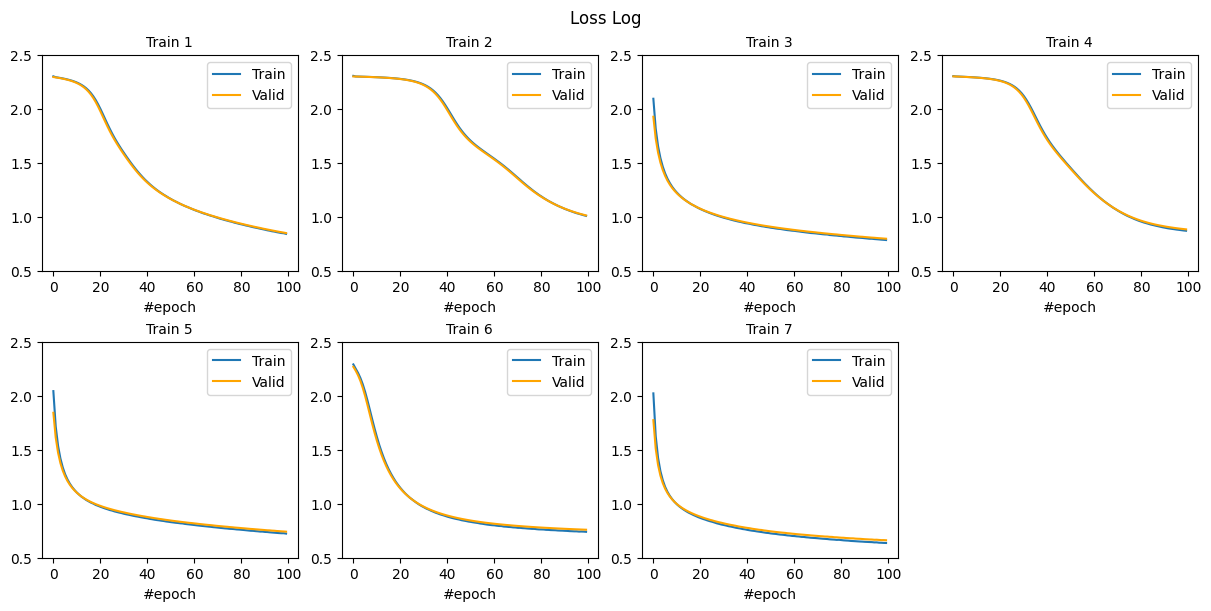

In [ ]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
for i in range(7):
  plt.subplot(2, 4, i+1)
  plt.plot(submodel_train_losses[i], label='Train')
  plt.plot(submodel_val_losses[i], label='Valid', color='orange')
  plt.xlabel('#epoch')
  plt.ylim(0.5, 2.5)
  plt.legend(loc='upper right')
  plt.title(f'Train {i+1}', fontdict={'size':10})

fig.suptitle('Loss Log')
plt.show()

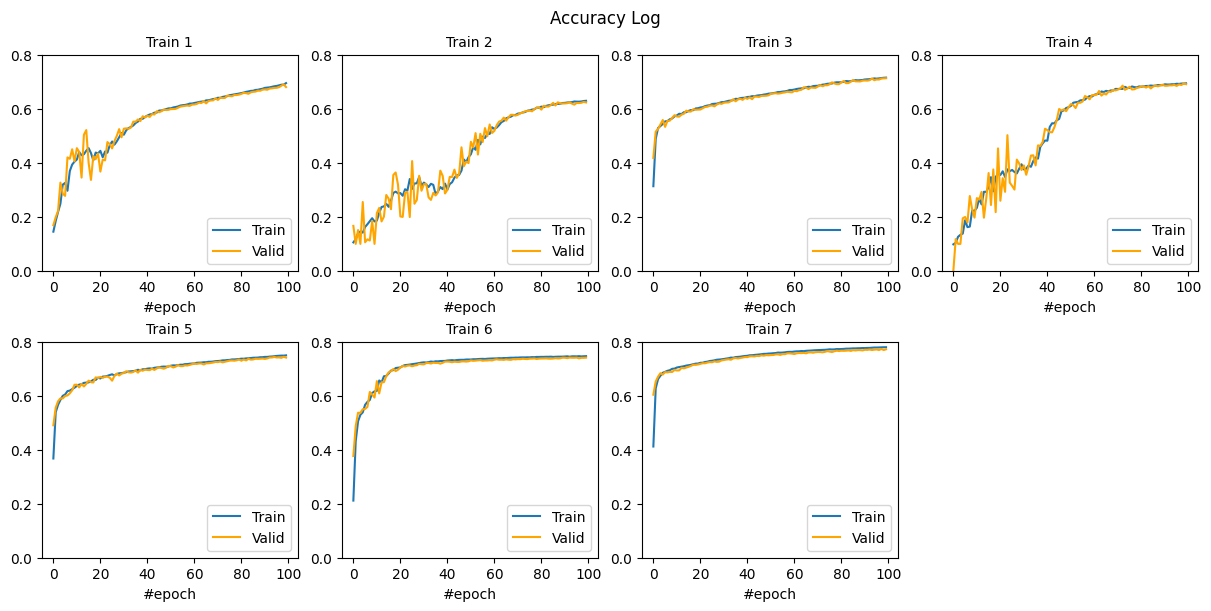

In [ ]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
for i in range(7):
  plt.subplot(2, 4, i+1)
  plt.plot(submodel_train_acc[i], label='Train')
  plt.plot(submodel_val_acc[i], label='Valid', color='orange')
  plt.xlabel('#epoch')
  plt.ylim(0.0, 0.8)
  plt.legend(loc='lower right')
  plt.title(f'Train {i+1}', fontdict={'size':10})

fig.suptitle('Accuracy Log')
plt.show()

After 7 train rounds, accuracy score reaches around 78% for both training set and validation set.

In [ ]:
import json
with open('log.txt', 'w') as f:
  f.write(json.dumps(log_dict))
with open('log_p6.txt', 'w') as f:
  f.write(json.dumps(log_p6))

In [ ]:
with open('log.txt', 'r') as f:
  log_dict = json.loads(f.read())
with open('log_p6.txt', 'r') as f:
  log_p6 = json.loads(f.read())